In [25]:
import pandas as pd
pd.options.mode.chained_assignment = None

# Because the dataset is pretty big, you can specify low_memory = False to make sure that you get the variable types correct on your rows
# The dataset has a additional column at the top that you can skip using the skiprows argument
raw_data = pd.read_csv("LendingClub2012to2013.csv", low_memory = False, skiprows=[0])

# Let's eliminate the rows that aren't "complete"
# There's a decision to make here... technically, any defaulted loan could pay off.
# So we will drop the current loans and the ones that are a few months late and leave behind the defaults and the paid off loans
no_incomplete_rows = raw_data[raw_data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
no_incomplete_rows['loan_status'] = no_incomplete_rows['loan_status'].apply(lambda x: 0 if x == "Fully Paid" else 1)
print(no_incomplete_rows.shape)

# notice we only lose about 16,000 loans.  why might this be?
# maximum term length for loans on lending club is 60 months


(171483, 115)


In [26]:
# now it's time to clear up the leakage and other stuff
leakage_to_drop = ['recoveries', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'last_credit_pull_d', 'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d', 'total_rec_late_fee', 'total_rec_int', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'out_prncp', 'out_prncp_inv', 'next_pymnt_d']
no_information_features_to_drop = ['all_util', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'total_bal_il', 'verification_status_joint', 'annual_inc_joint', 'application_type',  'policy_code', 'total_cu_tl']
text_columns = ['emp_title', 'url', 'desc', 'purpose', 'title', 'zip_code', 'id']


no_leakage = no_incomplete_rows.drop(text_columns + leakage_to_drop + no_information_features_to_drop, axis = 1)

no_leakage['earliest_cr_line'] = pd.to_datetime(no_leakage['earliest_cr_line'], format='%b-%Y')
no_leakage['time_since_earliest_cr_line'] = no_leakage['earliest_cr_line'].apply(lambda x: pd.to_datetime('20000101', format='%Y%m%d') - x).dt.days

# and it looks like there's a pesky % symbol in my interest rate variable
no_leakage['int_rate'] = pd.to_numeric(no_leakage['int_rate'].str.strip('%'), errors='coerce')
no_leakage['revol_util'] = pd.to_numeric(no_leakage['revol_util'].str.strip('%'), errors='coerce')

no_leakage['term'] = no_leakage['term'].apply(lambda x: x.strip().replace(" ", "_"))

no_leakage = no_leakage.drop(['earliest_cr_line'], axis = 1)

In [27]:
from sklearn import preprocessing

categorical = no_leakage.select_dtypes(include=['object'])
numeric = no_leakage.select_dtypes(exclude=['object'])

print(categorical.columns.values)

['term' 'grade' 'sub_grade' 'emp_length' 'home_ownership'
 'verification_status' 'issue_d' 'pymnt_plan' 'addr_state'
 'initial_list_status']


In [28]:
# create dummy variables
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)

term
grade
sub_grade
emp_length
home_ownership
verification_status
issue_d
pymnt_plan
addr_state
initial_list_status


In [29]:
# imputation
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
        
y = numeric['loan_status']
X = numeric.drop(['loan_status'], axis = 1)

member_id
loan_amnt
funded_amnt
funded_amnt_inv
int_rate
installment
annual_inc
loan_status
dti
delinq_2yrs
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
collections_12_mths_ex_med
mths_since_last_major_derog
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit
time_since_earliest_cr_line
term_36_months


In [30]:
import numpy as np
import pickle
loanData = no_leakage

##term
print ("Creating dummies for term")
loanData['term'] = [0 if x == " 36 months" else 1 for x in loanData['term']]

##grade
print ("creating dummies for grade")
loanData = loanData[pd.isnull(loanData['grade']) == 0]
loanData.index = range(len(loanData))
gradesdummy = pd.get_dummies(loanData['grade'])
loanData = pd.concat([loanData, gradesdummy], axis=1)
loanData = loanData.drop(['grade'], 1)
loanData = loanData.drop(['sub_grade'], 1)

#Verification Status
VerStatusdummy = pd.get_dummies(loanData['verification_status'])
loanData = pd.concat([loanData, VerStatusdummy], axis=1)
loanData = loanData.drop(['verification_status'], 1)

##emp_length
print ("Cleaning up emp_years")
emp_years = dict(zip(loanData['emp_length'].unique(), np.arange(loanData['emp_length'].nunique())))
loanData['emp_length'] = loanData['emp_length'].map(lambda x: emp_years[x])

homeOwnershipdummy = pd.get_dummies(loanData['home_ownership'])
loanData = pd.concat([loanData, homeOwnershipdummy], axis=1)
loanData = loanData.drop(['home_ownership'], 1)

##issue_month and issue_year
loanData['issue_month'] = 0
loanData['issue_year'] = 0

#issue_month
loanData['issue_month'] = [pd.to_datetime(x).month for x in loanData['issue_d']]
print ("Modifying issue_year")
loanData['issue_year'] = [pd.to_datetime(x).year for x in loanData['issue_d']]
print ("Dropping issue_d")
loanData = loanData.drop('issue_d', 1)

##pymnt_plan
print ("Creating dummies for pymnt_plan")
loanData['pymnt_plan'] = [1 if x == 'y' else 0 for x in loanData['pymnt_plan']]
loanData=loanData.drop('pymnt_plan', 1)

#addr_state
print ("creating dummies for addr_state")
statesdummy = pd.get_dummies(loanData['addr_state'])
loanData = pd.concat([loanData, statesdummy], axis=1)
loanData = loanData.drop('addr_state', 1)

##delinquencies
print ("Dropping null mths_since_last_delinq")
loanData['mths_since_last_delinq'] = [-1 if pd.isnull(x) else x for x in loanData['mths_since_last_delinq']]

##records
print ("Dropping null mths_since_last_record")
loanData['mths_since_last_record'] = [-1 if pd.isnull(x) else x for x in loanData['mths_since_last_record']]

##revol_util
loanData['revol_util'] = [-1 if pd.isnull(x) else x for x in loanData['revol_util']]

##initial_list_status
print ("cleaning up initial_list_status")
loanData['initial_list_status'] = [1 if x in ['w', 'W'] else 0 for x in loanData['initial_list_status']]

##major_derog
print ("Dropping nulls from mths_since_last_major_derog")
loanData['mths_since_last_major_derog'] = [-1 if pd.isnull(x) else x for x in loanData['mths_since_last_major_derog']]

##collections_12_mths_ex_med
print ("Dropping nulls from collections_12_mths_ex_med")
loanData['collections_12_mths_ex_med'] = [-1 if pd.isnull(x) else x for x in loanData['collections_12_mths_ex_med']]

##Remove features which aren't available for new loan listings

loanData = loanData.drop('initial_list_status', 1)



##Drop loans with missing values
loanData = loanData.dropna()
loanData.index = range(len(loanData))

loanData.to_csv("clean_LendingClub.csv")

Creating dummies for term
creating dummies for grade
Cleaning up emp_years
Modifying issue_year
Dropping issue_d
Creating dummies for pymnt_plan
creating dummies for addr_state
Dropping null mths_since_last_delinq
Dropping null mths_since_last_record
cleaning up initial_list_status
Dropping nulls from mths_since_last_major_derog
Dropping nulls from collections_12_mths_ex_med


In [31]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

clean_data = pd.read_csv("clean_LendingClub.csv", low_memory = False, skiprows=[1])
#clean_data = loanData
y = clean_data['loan_status']
X = clean_data.drop(['loan_status'], axis = 1)





In [32]:
# create a holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

[  7.42  12.13  16.01  18.92  21.79  24.23  26.66  28.7   30.54  32.26
  33.7   35.09  36.37  37.54  38.66  39.76  40.81  41.82  42.82  43.77
  44.71  45.63  46.54  47.43  48.31  49.18  50.04  50.9   51.75  52.59
  53.43  54.26  55.09  55.92  56.74  57.56  58.38  59.2   60.01  60.82
  61.63  62.44  63.25  64.06  64.87  65.68  66.49  67.29  68.09  68.89
  69.69  70.49  71.29  72.09  72.89  73.69  74.49  75.29  76.09  76.89
  77.68  78.47  79.26  80.05  80.84  81.63  82.41  83.19  83.96  84.73
  85.49  86.25  87.01  87.75  88.49  89.21  89.93  90.62  91.29  91.93]
[[ 1.1816751  -1.08596238 -0.12434103 ..., -0.72322241 -1.04989882
   0.55273432]
 [-2.43071896 -2.88059479 -1.2443204  ..., -0.13210208  0.75662175
  -0.87322032]
 [-3.32127717  1.7841403   0.21313793 ..., -0.32427987 -1.35083379
  -0.2137421 ]
 ..., 
 [ 1.17758975  2.26609095  2.05924152 ..., -1.03312724 -0.99199119
   0.61064264]
 [-3.7419734  -1.90775334 -1.08681634 ..., -0.59094058 -1.48024641
  -0.73316533]
 [ 0.13040723 

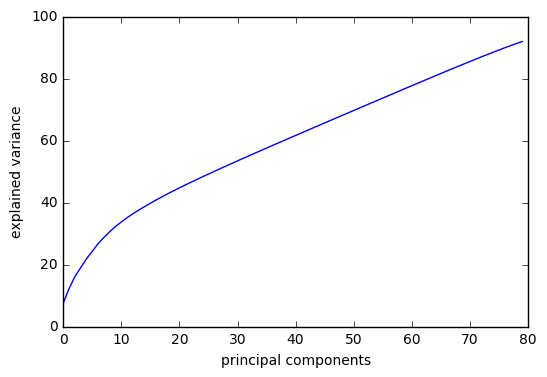

In [33]:
# Prinipal Component Analysis


k_train= X_train.values
k_test = X_test.values

#Scaling the values
k_train = scale(k_train)
k_test = scale(k_test)

pca = PCA(n_components=80)

# Fitting pca on X_train
pca.fit(k_train)

#Amount of variance explained by each PC
var= pca.explained_variance_ratio_

#Cumulative variance
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

# Printing individual component variances and plotting them
print(var1)
plt.plot(var1)
plt.xlabel("principal components")
plt.ylabel("explained variance")

#Looking at above plot I'm taking 80 variables
pca = PCA(n_components=80)
pca.fit(k_train)

# Trasforming X_train and X_test
X_t_train=pca.fit_transform(k_train)
X_t_test = pca.fit_transform(k_test)

print(X_t_train)


In [34]:
## one layer ANN WITHOUT PCA on train set(without transformation)

from time import time
from keras.models import Sequential
from keras.layers import Dense, Activation

np.random.seed(1337)

start = time()

model = Sequential()
model.add(Dense(100, input_dim=130))
model.add(Activation("softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(k_train, y_train, epochs=10)

scores = model.evaluate(k_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("One layer NN trained")

Epoch 1/10
23319/23319 [==============================] - 1s - loss: 2.7819 - acc: 0.5308     
Epoch 2/10
23319/23319 [==============================] - 1s - loss: 0.9865 - acc: 0.8307     
Epoch 3/10
23319/23319 [==============================] - 1s - loss: 0.7632 - acc: 0.8343     
Epoch 4/10
23319/23319 [==============================] - 1s - loss: 0.6708 - acc: 0.8351     
Epoch 5/10
23319/23319 [==============================] - 1s - loss: 0.6080 - acc: 0.8373     
Epoch 6/10
23319/23319 [==============================] - 1s - loss: 0.5610 - acc: 0.8371     
Epoch 7/10
23319/23319 [==============================] - 1s - loss: 0.5260 - acc: 0.8372     
Epoch 8/10
23319/23319 [==============================] - 1s - loss: 0.5009 - acc: 0.8376     
Epoch 9/10
23319/23319 [==============================] - 1s - loss: 0.4834 - acc: 0.8376     
Epoch 10/10
22528/23319 [===========================>..] - ETA: 0s
acc: 83.73%
One layer NN trained


In [35]:
## one layer ANN WITH PCA on Training Set(Transformed)

from time import time
from keras.models import Sequential
from keras.layers import Dense, Activation

np.random.seed(1337)

start = time()

model = Sequential()
model.add(Dense(30, input_dim=80))
model.add(Activation("softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_t_train, y_train, epochs=10)

scores = model.evaluate(X_t_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("One layer NN trained")

Epoch 1/10
23319/23319 [==============================] - 1s - loss: 2.1378 - acc: 0.5263     
Epoch 2/10
23319/23319 [==============================] - 0s - loss: 0.8091 - acc: 0.8316     
Epoch 3/10
23319/23319 [==============================] - 1s - loss: 0.6570 - acc: 0.8348     
Epoch 4/10
23319/23319 [==============================] - 1s - loss: 0.5889 - acc: 0.8353     
Epoch 5/10
23319/23319 [==============================] - 0s - loss: 0.5437 - acc: 0.8365     
Epoch 6/10
23319/23319 [==============================] - 1s - loss: 0.5129 - acc: 0.8368     
Epoch 7/10
23319/23319 [==============================] - 1s - loss: 0.4916 - acc: 0.8366     
Epoch 8/10
23319/23319 [==============================] - 1s - loss: 0.4769 - acc: 0.8371     
Epoch 9/10
23319/23319 [==============================] - 1s - loss: 0.4668 - acc: 0.8370     
Epoch 10/10
22976/23319 [============================>.] - ETA: 0s
acc: 83.75%
One layer NN trained


In [36]:
## Accuracy of one layer ANN WITH PCA

y_prediction = model.predict_classes(X_t_test)
print ("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

3552/5830 [=================>............] - ETA: 0s

accuracy 0.83859348199


In [37]:
## Two layer ANN WITH PCA

model = Sequential()
model.add(Dense(30,input_dim=80))
model.add(Dense(output_dim=20))
model.add(Activation("softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_t_train, y_train)

print("Two layer NN trained")



C:\Users\Rajan\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=20)`


Epoch 1/10
23319/23319 [==============================] - 1s - loss: 1.0673 - acc: 0.7219     
Epoch 2/10
23319/23319 [==============================] - 0s - loss: 0.4500 - acc: 0.8369     
Epoch 3/10
23319/23319 [==============================] - 0s - loss: 0.4296 - acc: 0.8371     
Epoch 4/10
23319/23319 [==============================] - 0s - loss: 0.4245 - acc: 0.8367     
Epoch 5/10
23319/23319 [==============================] - 0s - loss: 0.4220 - acc: 0.8373     
Epoch 6/10
23319/23319 [==============================] - 1s - loss: 0.4210 - acc: 0.8365     
Epoch 7/10
23319/23319 [==============================] - 1s - loss: 0.4198 - acc: 0.8371     
Epoch 8/10
23319/23319 [==============================] - 1s - loss: 0.4193 - acc: 0.8373     
Epoch 9/10
23319/23319 [==============================] - 1s - loss: 0.4187 - acc: 0.8370     
Epoch 10/10
23319/23319 [==============================] - 1s - loss: 0.4181 - acc: 0.8379     
Two layer NN trained


In [38]:
## Accuracy of Two layer ANN WITH PCA

y_prediction = model.predict_classes(X_t_test)
print ("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

3680/5830 [=================>............] - ETA: 0s 

accuracy 0.838250428816


In [39]:
## Three layer ANN WITH PCA

model = Sequential()
model.add(Dense(30,input_dim=80))
model.add(Dense(output_dim=20))
model.add(Dense(output_dim=2))
model.add(Activation("softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_t_train, y_train)

print("Three layer NN trained")


C:\Users\Rajan\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=20)`
C:\Users\Rajan\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=2)`


Epoch 1/10
23319/23319 [==============================] - 1s - loss: 0.4570 - acc: 0.8174     
Epoch 2/10
23319/23319 [==============================] - 0s - loss: 0.4211 - acc: 0.8373     
Epoch 3/10
23319/23319 [==============================] - 0s - loss: 0.4195 - acc: 0.8372     
Epoch 4/10
23319/23319 [==============================] - 0s - loss: 0.4186 - acc: 0.8376     
Epoch 5/10
23319/23319 [==============================] - 0s - loss: 0.4181 - acc: 0.8367     
Epoch 6/10
23319/23319 [==============================] - 0s - loss: 0.4181 - acc: 0.8372     
Epoch 7/10
23319/23319 [==============================] - 0s - loss: 0.4179 - acc: 0.8370     
Epoch 8/10
23319/23319 [==============================] - 0s - loss: 0.4179 - acc: 0.8368     
Epoch 9/10
23319/23319 [==============================] - 0s - loss: 0.4175 - acc: 0.8373     
Epoch 10/10
23319/23319 [==============================] - 0s - loss: 0.4180 - acc: 0.8367     
Three layer NN trained


In [120]:
## GridsearchCV for 3 layer ANN WITHOUT PCA on train set
## for optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy

# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
# create model
    model = Sequential()
    model.add(Dense(100, input_dim=131, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
# Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
#init = ['glorot_uniform', 'normal', 'uniform']
epochs = [10]
#batches = [5, 8]
param_grid = dict(optimizer=optimizers, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(k_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.390111 using {'optimizer': 'rmsprop', 'epochs': 10}
0.390111 (0.318920) with: {'optimizer': 'rmsprop', 'epochs': 10}
0.384450 (0.316544) with: {'optimizer': 'adam', 'epochs': 10}


In [122]:
## GridsearchCV on 3 layer ANN WITH PCA on train set(Transformed)
## for optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy

# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
# create model
    model = Sequential()
    model.add(Dense(30, input_dim=80, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
# Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
#init = ['glorot_uniform', 'normal', 'uniform']
epochs = [10]
#batches = [5, 8]
param_grid = dict(optimizer=optimizers, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_t_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.832883 using {'optimizer': 'rmsprop', 'epochs': 10}
0.832883 (0.005856) with: {'optimizer': 'rmsprop', 'epochs': 10}
0.831854 (0.005737) with: {'optimizer': 'adam', 'epochs': 10}


In [ ]:
## Working on this part - 3 layer ANN WITH PCA on train set(Transformed)
# optimizing batch size and epochs 
#### STILL TESTING ######

# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=80, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)
# define the grid search parameters
optimizer = ['Adagrad', 'Adadelta', 'Adam', 'Adamax']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_t_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [107]:
##Additional methods

y_train = y_train[:, np.newaxis]
postpca_train = np.hstack((X_t_train, y_train))

In [ ]:
## Naive Bayes

from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
#target_pred = clf.predict(features_test)

In [108]:
postpca_train.shape

(137186, 41)

In [109]:
# K means Clustering
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=2)
k_fit = k_means.fit(X_train) 

In [117]:
k_means

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

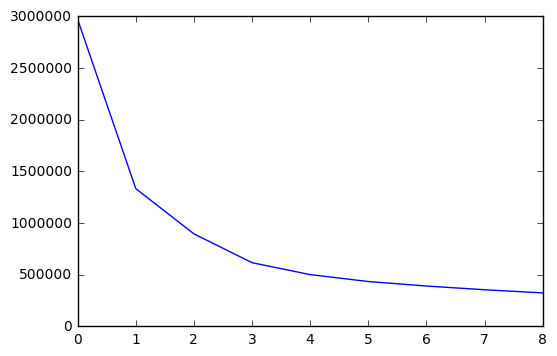

In [120]:
from scipy import cluster
from matplotlib import pyplot

initial = [cluster.vq.kmeans(postpca_train,i) for i in range(1,10)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

In [122]:
cent, var = initial[1]
#use vq() to get as assignment for each obs.
assignment,cdist = cluster.vq.vq(postpca_train,cent)
pyplot.scatter(postpca_train[:,0],postpca_train[:,1], c=assignment)
pyplot.show()

TypeError: scatter() missing 1 required positional argument: 'y'

In [8]:
# Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.5, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [11]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.1263


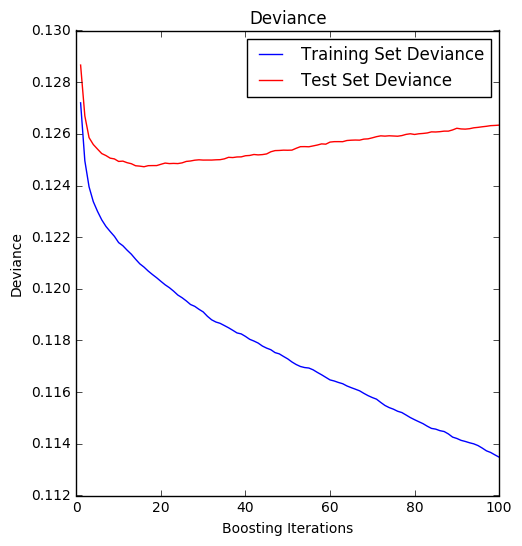

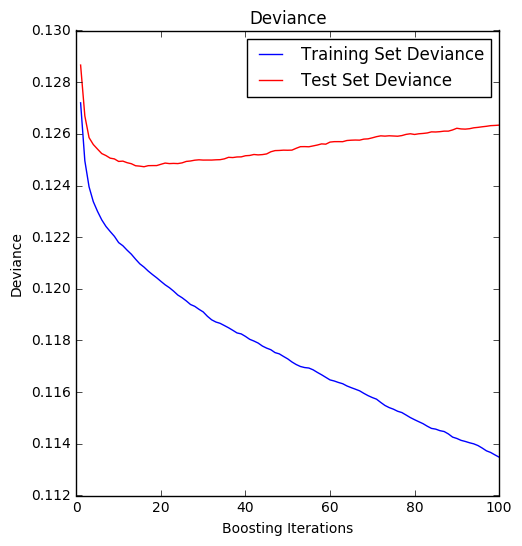

In [13]:
import matplotlib.pyplot as plt

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

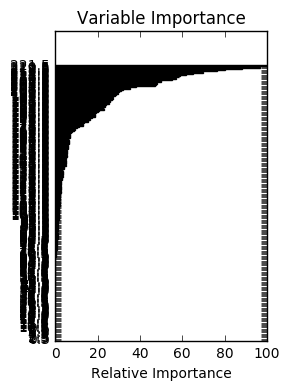

In [14]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }

est = GradientBoostingRegressor(n_estimators=3000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

C:\Users\Rajan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Rajan\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [63]:
# K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor

data_knn = KNeighborsRegressor(n_neighbors = 1000, metric='euclidean')
data_knn

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=1000, p=2,
          weights='uniform')

In [64]:
data_knn.fit(X_train, y_train)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=1000, p=2,
          weights='uniform')

In [62]:
(y_train==0).sum()

115183

In [113]:
k=data_knn.predict(X_train)
r=k-y_train
r

157872   -0.848
53128     0.180
166529    0.203
165519    0.159
79502    -0.818
105426    0.181
19639     0.153
73191     0.145
165423    0.185
149389    0.176
91104     0.203
139519    0.147
123356    0.135
13026     0.124
118575    0.165
126291    0.163
180479   -0.851
175440    0.195
107771    0.197
177912    0.181
28667    -0.832
76505     0.181
130796    0.131
16007     0.166
11636    -0.897
4472      0.170
130102    0.171
104772   -0.819
127245    0.154
120947    0.173
          ...  
187276   -0.821
27812     0.167
87252    -0.798
58578     0.181
88585     0.156
168621    0.174
169329   -0.754
150085   -0.822
117230    0.167
183872    0.172
57140     0.168
131264    0.128
105848    0.184
83598     0.174
90781     0.200
139714    0.174
140056    0.176
83942     0.165
10068     0.172
47219    -0.813
181464    0.169
154673    0.181
170829    0.217
11709    -0.875
47856     0.179
64523    -0.838
37738     0.209
93903     0.189
136373    0.112
181604    0.176
Name: loan_status, dtype

In [111]:
m = k
n = k
for x in range(n.size):
    m[x] = 1 if n[x] > 0.5 else 0
    
m

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [107]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, m))

0.839611913752


In [40]:
data_knn.get_params()


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 10,
 'p': 2,
 'weights': 'uniform'}

In [41]:
rsquared_train = data_knn.score(X_train, y_train)
rsquared_test = data_knn.score(X_test, y_test)
print ('Training data R-squared:')
print(rsquared_train)
print ('Test data R-squared:')
print(rsquared_test)

Training data R-squared:
0.841179129066
Test data R-squared:
0.836166428551


In [12]:
# confusion matrix
from sklearn.metrics import confusion_matrix

knn_confusion_matrix = confusion_matrix(y_true = y_test, y_pred = data_knn.predict(X_test))
print("The Confusion matrix:\n", knn_confusion_matrix)

The Confusion matrix:
 [[28648    88]
 [ 5531    30]]


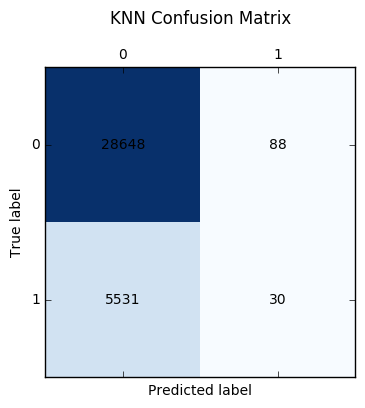

In [13]:
import matplotlib.pyplot as plt

# visualize the confusion matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
plt.matshow(knn_confusion_matrix, cmap = plt.cm.Blues)
plt.title("KNN Confusion Matrix\n")
#plt.xticks([0,1], ['No', 'Yes'])
#plt.yticks([0,1], ['No', 'Yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for y in range(knn_confusion_matrix.shape[0]):
    for x in range(knn_confusion_matrix.shape[1]):
        plt.text(x, y, '{}'.format(knn_confusion_matrix[y, x]),
                horizontalalignment = 'center',
                verticalalignment = 'center',)
plt.show()

In [14]:
#Generate the classification report
from sklearn.metrics import classification_report
knn_classify_report = classification_report(y_true = y_test, 
                                           y_pred = data_knn.predict(X_test))
print(knn_classify_report)

             precision    recall  f1-score   support

          0       0.84      1.00      0.91     28736
          1       0.25      0.01      0.01      5561

avg / total       0.74      0.84      0.76     34297



In [57]:
pred = data_knn.predict(X_test)

In [58]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

0.83785753856
